In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import distinctipy as dpy
import colormaps as cmaps

from tqdm import tqdm
from sklearn.cluster import DBSCAN


In [4]:
dfs = {
    "250" : pd.read_csv("./tsne_alivhep_k250_test.csv"),
    "500" : pd.read_csv("./tsne_alivhep_k500_test.csv"),
    "1000" : pd.read_csv("./tsne_alivhep_k1000_test.csv"),
    "2500" : pd.read_csv("./tsne_alivhep_k2500_test.csv"),
    "5000" : pd.read_csv("./tsne_alivhep_k5000_test.csv"),
}

for name, df in dfs.items():
    df["k"] = int(name)
    df["sample_a"] = df["sample_n"] / df["sample_n"].max()

df_full = pd.concat(dfs.values(), ignore_index=True)

n_dfs = len(dfs)
tcolumns = columns = ["tsne0", "tsne1"]

df_full

,tsne0,tsne1,label,file_n,sample_n,file_name,k,sample_a
0,-21.906370,4.680918,liver_hepatocytes,0,3414,liver_hepatocytes_5000(3),250,0.679944
1,20.436651,-52.767826,liver_hepatocytes,0,4609,liver_hepatocytes_5000(3),250,0.917945
2,-4.020654,17.711393,liver_hepatocytes,0,1990,liver_hepatocytes_5000(3),250,0.396335
3,-10.092237,-16.009220,liver_hepatocytes,0,1341,liver_hepatocytes_5000(3),250,0.267078
4,7.086719,51.381832,liver_hepatocytes,0,2265,liver_hepatocytes_5000(3),250,0.451105
...,...,...,...,...,...,...,...,...
40563,-42.083510,68.578530,liver_hepatocytes,15,4312,liver_hepatocytes_5000(0),5000,0.858793
40564,-42.942204,70.459770,liver_hepatocytes,15,4359,liver_hepatocytes_5000(0),5000,0.868154
40565,-48.286710,-9.951856,liver_hepatocytes,15,1212,liver_hepatocytes_5000(0),5000,0.241386
40566,-30.004337,-12.899682,liver_hepatocytes,15,3270,liver_hepatocytes_5000(0),5000,0.651265


In [15]:
def dbscan_cluster(df, columns, eps, min_samples):
    X = df[columns].values
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    clustering = clustering.labels_

    max_i = max(clustering)

    for i, c in enumerate(clustering):
        if c == -1:
            max_i += 1
            clustering[i] = max_i

    return clustering

def get_clusterings(columns, eps , min_samples) -> dict[str, list[int]]:
    clusterings = {
        name : dbscan_cluster(dfs[name], columns, eps, min_samples)
        for name in dfs.keys()
    }

    return clusterings

def get_clusterings_ns(clusterings) -> dict[str,int]:
    clusterings_ns = {
        name : len(set(clusterings[name]))
        for name in tqdm(dfs.keys(), desc="Counting")
    }

    return clusterings_ns

epss = np.arange(1, 3.5, 0.25)

clusterings = get_clusterings(tcolumns, 2, 5)            
clusterings_ns = get_clusterings_ns(clusterings)

clusterings_ns_by_eps = [
    (eps, list(get_clusterings_ns(get_clusterings(tcolumns, eps, 5)).values()))
    for eps in epss
]

cluster_colors = dpy.get_colors(10, pastel_factor=0.8)
cluster_colors = cluster_colors * (max(clusterings_ns.values()) // 10 + 1)

Counting: 100%|██████████| 5/5 [00:00<00:00, 1603.08it/s]


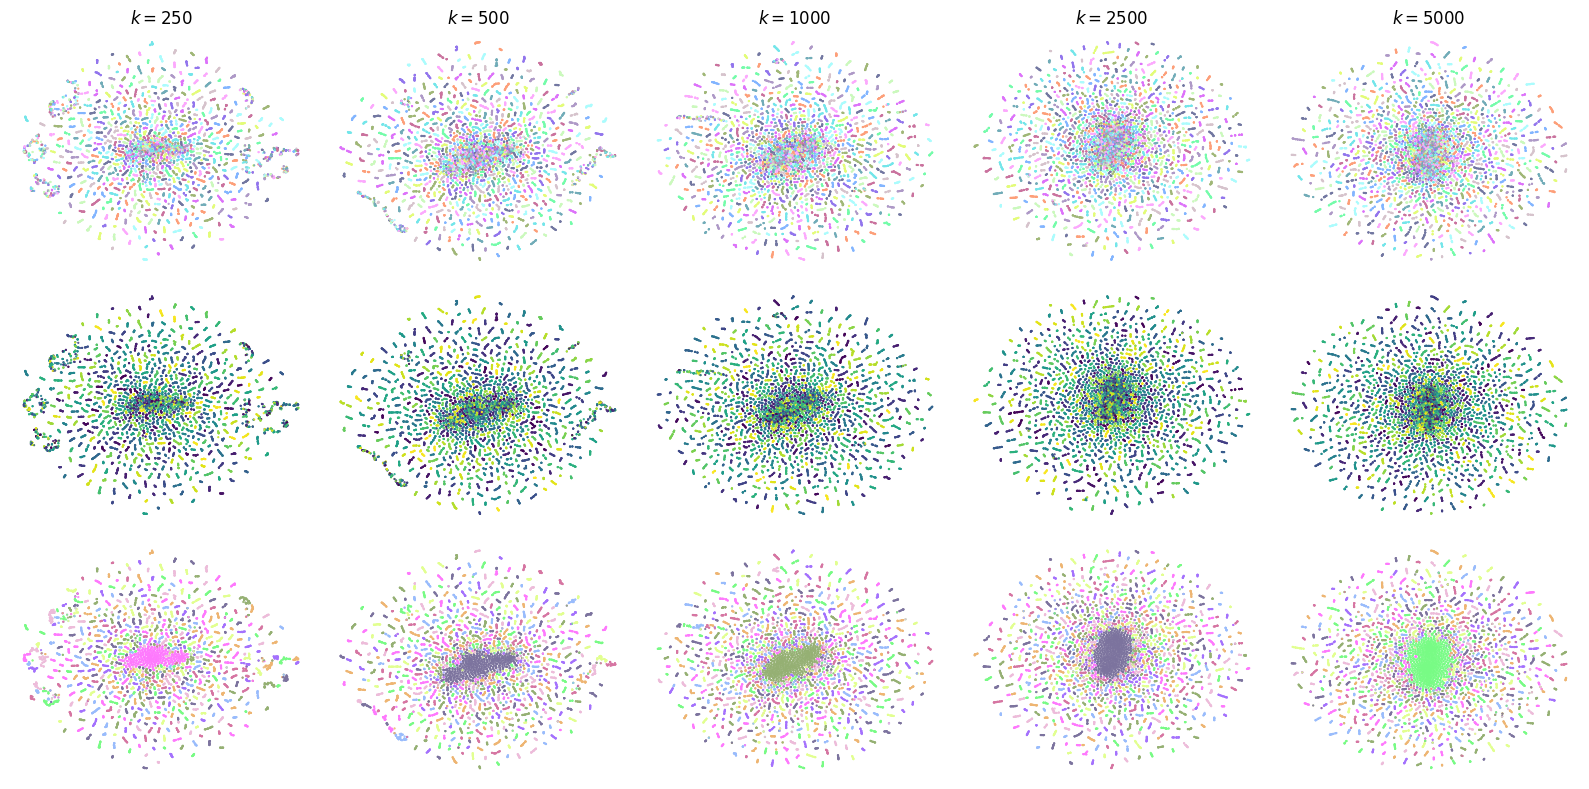

In [18]:
fig, (axs1, axs2, axs3) = plt.subplots(3, n_dfs, figsize=(16,8))

run_colors = np.array( dpy.get_colors(df_full['file_n'].nunique(), pastel_factor=0.8))

def plot_tsnes(df : pd.DataFrame, ax, name=None, colors="file_n"):
    if type(colors) is str:
        colors = run_colors[df[colors].values]

    ax.scatter(df[tcolumns[0]], df[tcolumns[1]], s=0.3, c=colors)
    if name is not None:
        ax.set_title(f"$k={name}$")

    ax.axis('off')

for (name, df), ax in zip(dfs.items(), axs1):
    plot_tsnes(df, ax, name)

for (name, df), ax in zip(dfs.items(), axs2):
    plot_tsnes(df, ax, colors=df["sample_a"])

for (name, df), ax in zip(dfs.items(), axs3):
    plot_tsnes(df, ax, colors=np.array(cluster_colors)[clusterings[name]])

axs1[0].set_xlabel("Run")
axs2[0].set_xlabel("Sample N")
axs3[0].set_xlabel("DBScan")

fig.tight_layout()
fig.savefig("tsne_run_colors.png", dpi=600)

In [19]:

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ns_colors = cmaps.matter.discrete(len(epss)).colors

for i, (eps, ns) in enumerate(clusterings_ns_by_eps):
    ax.plot(ns, label=eps, c=ns_colors[i])
    ax.set_xticks(list(range(len(clusterings))), clusterings.keys())

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='$\epsilon$')
ax.set_title("$N_{cluster}$ Found")
ax.set_xlabel("$k$")
ax.set_ylabel("$N_{cluster}$")

fig.tight_layout()
plt.savefig("tsne_dbscan.png", dpi=400)

SyntaxError: unmatched ']' (3790655150.py, line 6)